In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('/content/drive/MyDrive/PKM')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load CSV files that is filled with

In [2]:
#LOAD TWEETS CSV FILES
jokowi = pd.read_csv('/content/drive/MyDrive/PKM/tweet-jokowi.csv')
dpr = pd.read_csv('/content/drive/MyDrive/PKM/tweet-dpr.csv')

Combine jokowi's tweet and dpr's tweet

In [3]:
#COMBINE TWEET JOKOWI AND DPR
df = pd.concat([jokowi, dpr], ignore_index=True)
df = df.reset_index(drop=True)
print(f"Dataframe tweet gabungan : {df.shape}")

Dataframe tweet gabungan : (248920, 4)


Let's drop another unneeded columns

In [4]:
df = df.drop(['name', 'username'], axis=1)

Twitter's tweet will definitely be full of punctuations, emotes, urls, mentions, and hastags. Since we don't need them, we can safely remove. It can also help to reduce the memory of the dataframe

In [5]:
import re
import string

def clean_text(text):
    text = re.sub("@[A-Za-z0-9]+","", text)
    text = re.sub("_[A-Za-z0-9]+", "", text)
    text = re.sub("#[A-Za-z0-9]+", "", text)
    text = text.lower()
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE), "", text)
    return text

df['tweet'] = df['tweet'].apply(lambda x : clean_text(x))

Let's drop the tweets that are duplicates

In [6]:
print(f'Dataframe shape before delete duplicated tweets : {df.shape}')
df = df.drop_duplicates(subset=['tweet'])
print(f'Dataframe shape after delete duplicated tweets : {df.shape}')

Dataframe shape before delete duplicated tweets : (248920, 2)
Dataframe shape after delete duplicated tweets : (203399, 2)


So our goal is to find most frquent words so that we can filter the tweet to tweets that are actually meant to be a complaint to DPR and Jokowi and. After we find the top 100 most frequent words, we then filter the dataframe by dropping the tweet if the tweet doesn't contain any of the 100 most frequent words.

We actually needed the whole tweet after removing punctuations, emotes, hastags, etc. So we make a copy of the tweets first

In [7]:
tweet_copy = df['tweet']

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Create a WordCloud from the tweets

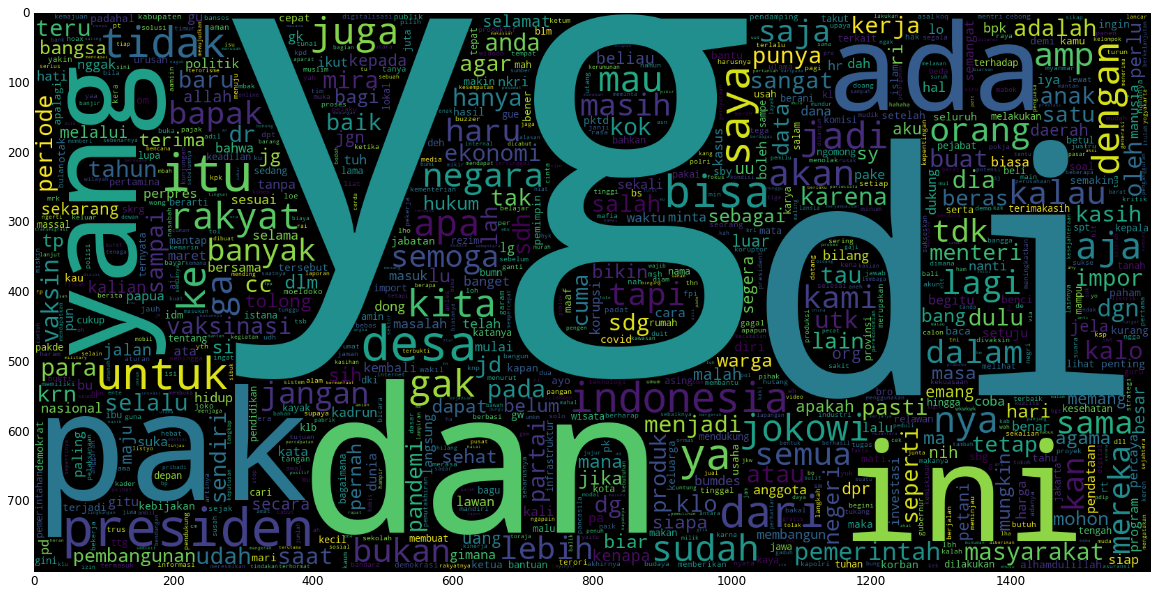

In [9]:
plt.figure(figsize=(20,20))
plt.style.use('classic')
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(tweet_copy))
plt.imshow(wc)

As we can see, we still see a lot of unneeded words, such as di, yg, dan, ada, ini, etc. Since it doesn't really can categorize which is a complaint tweet or not, we can safely remove the words

First, we remove stopwords. Then, we still have unneeded words that is not included in the stopwords library. So, we can add them manually put the words into a txt file and remove them from the tweets

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def clean(textData):
    processedText = []
    #REMOVE STOPWORDS AND STEM
    for word in textData.split():
        if word not in stopwords:
            processedText.append(word)
                    
    return " ".join(processedText)

tweet_copy = tweet_copy.apply(lambda x : clean(x))

In [12]:
unused_words = []

with open('/content/drive/MyDrive/PKM/unused_words.txt') as f:
    for words in f:
        unused_words.append(words.strip())

In [13]:
def clean(textData):
    processedText = []
    #REMOVE STOPWORDS AND STEM
    for word in textData.split():
        if word not in unused_words:
            processedText.append(word)
                    
    return " ".join(processedText)

tweet_copy = tweet_copy.apply(lambda x : clean(x))

After removing few words, let's try to see the wordcloud again

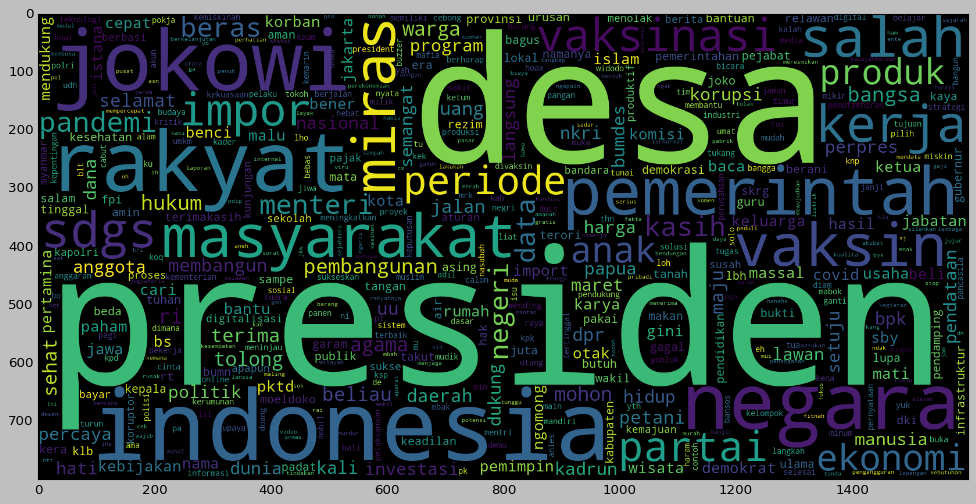

In [14]:
plt.figure(figsize=(15,15))
plt.style.use('classic')
wc = WordCloud(max_words=500, width=1600, height=800, collocations=False).generate(" ".join(tweet_copy))
plt.imshow(wc)

As we can see, we finally see some words that are pretty good to filter out the complaint tweets.

Next step, we pick the top 100 most frequent words from the tweets and use it to filter out the tweets. If the tweet doesn't contain any from the top 100 most frequent words, the tweet is deleted.

In [15]:
from collections import Counter
most_frequent_words = Counter(" ".join(tweet_copy).split()).most_common(100)
words = [x[0] for x in most_frequent_words]

unused = ['ri', 'in', 'of', '🤣']
for x in unused:
    words.remove(x)

In [16]:
words

['presiden',
 'desa',
 'indonesia',
 'rakyat',
 'jokowi',
 'negara',
 'pemerintah',
 'masyarakat',
 'vaksin',
 'miras',
 'salah',
 'kerja',
 'sdgs',
 'impor',
 'vaksinasi',
 'partai',
 'periode',
 'ekonomi',
 'anak',
 'produk',
 'pandemi',
 'kasih',
 'menteri',
 'data',
 'negeri',
 'beras',
 'pembangunan',
 'bangsa',
 'hukum',
 'warga',
 'agama',
 'mohon',
 'tolong',
 'terima',
 'sehat',
 'beliau',
 'uang',
 'selamat',
 'dpr',
 'maju',
 'jalan',
 'uu',
 'daerah',
 'petani',
 'membangun',
 'kadrun',
 'dana',
 'bpk',
 'setuju',
 'bumdes',
 'nkri',
 'anggota',
 'hidup',
 'perpres',
 'papua',
 'program',
 'politik',
 'korupsi',
 'pendataan',
 'hati',
 'langsung',
 'percaya',
 'harga',
 'nasional',
 'semangat',
 'lawan',
 'kali',
 'investasi',
 'maret',
 'manusia',
 'dunia',
 'dukung',
 'kebijakan',
 'bantu',
 'ketua',
 'hasil',
 'demokrat',
 'baca',
 'pktd',
 'islam',
 'covid',
 'pemimpin',
 'cepat',
 'keluarga',
 'mati',
 'benci',
 'korban',
 'bener',
 'jabatan',
 'paham',
 'usaha',
 'sby

In [17]:
def filtering(text):
    if re.compile('|'.join(words), re.IGNORECASE).search(text):
        return text
    else:
        return np.NaN

In [18]:
df['tweet'] = df['tweet'].apply(lambda x : filtering(x))
df = df.dropna().reset_index(drop=True)

Now, we move into the predicting the sentiment of the tweet. Thankfully, we already have pre_trained model from indonNLU. The code can be seen here : https://github.com/indobenchmark/indonlu/blob/master/examples/finetune_smsa.ipynb

In [19]:
!pip install transformers

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from utils.forward_fn import forward_sequence_classification
from utils.metrics import document_sentiment_metrics_fn
from utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

#Load Model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

     |████████████████████████████████| 2.5 MB 10.5 MB/s 
     |████████████████████████████████| 3.3 MB 58.3 MB/s 
     |████████████████████████████████| 895 kB 59.7 MB/s 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

count_param(model)

124443651

In [22]:
train_dataset_path = '/content/drive/MyDrive/PKM/smsa_doc-sentiment-prosa/train_preprocess.tsv'
valid_dataset_path = '/content/drive/MyDrive/PKM/smsa_doc-sentiment-prosa/valid_preprocess.tsv'

In [23]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


In [25]:
from torch import optim
import torch
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [26]:
from tqdm import tqdm

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

  0%|          | 0/344 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/40 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.3285 ACC:0.88 F1:0.83 REC:0.81 PRE:0.86 LR:0.00000300


VALID LOSS:0.1949 ACC:0.93 F1:0.89 REC:0.88 PRE:0.90: 100%|██████████| 40/40 [00:08<00:00,  4.80it/s]
  0%|          | 0/344 [00:00<?, ?it/s]

(Epoch 1) VALID LOSS:0.1949 ACC:0.93 F1:0.89 REC:0.88 PRE:0.90


  0%|          | 0/40 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.1571 ACC:0.95 F1:0.93 REC:0.93 PRE:0.94 LR:0.00000300


VALID LOSS:0.1721 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]
  0%|          | 0/344 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.1721 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92


  0%|          | 0/40 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.1198 ACC:0.96 F1:0.95 REC:0.95 PRE:0.95 LR:0.00000300


VALID LOSS:0.1856 ACC:0.93 F1:0.91 REC:0.89 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]
  0%|          | 0/344 [00:00<?, ?it/s]

(Epoch 3) VALID LOSS:0.1856 ACC:0.93 F1:0.91 REC:0.89 PRE:0.92


  0%|          | 0/40 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0929 ACC:0.97 F1:0.96 REC:0.96 PRE:0.97 LR:0.00000300


VALID LOSS:0.1992 ACC:0.93 F1:0.91 REC:0.91 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.61it/s]
  0%|          | 0/344 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.1992 ACC:0.93 F1:0.91 REC:0.91 PRE:0.92


  0%|          | 0/40 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0668 ACC:0.98 F1:0.98 REC:0.97 PRE:0.98 LR:0.00000300


VALID LOSS:0.1880 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92: 100%|██████████| 40/40 [00:08<00:00,  4.66it/s]

(Epoch 5) VALID LOSS:0.1880 ACC:0.94 F1:0.91 REC:0.90 PRE:0.92


In [27]:
import torch.nn.functional as F

text = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita | Label : positive (99.654%)


In [28]:
def predict_sentiment(text):
  subwords = tokenizer.encode(text)
  subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

  logits = model(subwords)[0]
  label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

  return f'{i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)'

df['sentiment'] = df['tweet'].apply(lambda x : predict_sentiment(x))

In [29]:
df

,likes_count,tweet,sentiment
0,0,abdi negara,positive (63.790%)
1,3,gus menteri anak kandung kementerian desa pdt...,neutral (99.391%)
2,6,tenaga pendamping profesional tpp kemendesa pd...,neutral (99.486%)
3,2,pendamping desa menjadi corong kemendes ...,neutral (99.545%)
4,2,setuju bedil wae mba ndak ada ham ham an,negative (98.366%)
...,...,...,...
133922,1,iya kak semoga saja syarat yg dibuat p...,positive (95.386%)
133923,0,anggota dpr yang sibuk urus ...,negative (98.758%)
133924,1,berdoa semoga tahun ini tahun pemba...,positive (86.311%)
133925,0,faiz sang penghafal al quran kelak akan bertan...,negative (48.827%)


In [30]:
df['percentage'] = df['sentiment'].apply(lambda x : x.split(" ")[1])
df['sentiment'] = df['sentiment'].apply(lambda x : x.split(" ")[0])

Let's check the sentiment results

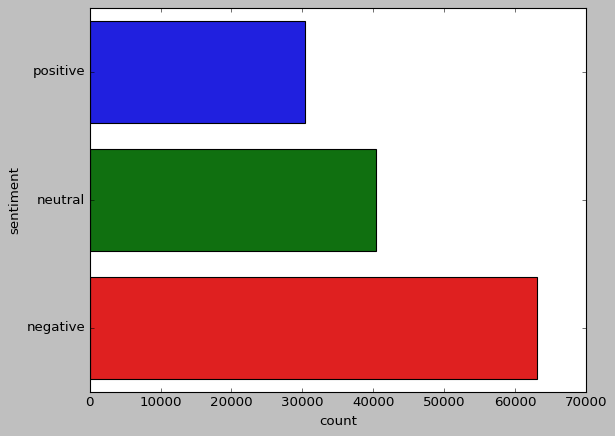

In [31]:
import seaborn as sns

sns.countplot(y = df['sentiment'])

In [32]:
df[df['sentiment'] == 'neutral'][['tweet', 'sentiment']]

,tweet,sentiment
1,gus menteri anak kandung kementerian desa pdt...,neutral
2,tenaga pendamping profesional tpp kemendesa pd...,neutral
3,pendamping desa menjadi corong kemendes ...,neutral
6,pendamping desa lahir dari rahim kemendesa pdt...,neutral
9,penghargaan dr kemendesa kepada kepala desa at...,neutral
...,...,...
133895,dpr sebut pengambilalihan blok rokan jadi tong...,neutral
133896,dari anggota komisi xi selamat atas berdir...,neutral
133899,sumba ntt di guncang gempa pertama di smg tak...,neutral
133911,launching kartu pelanggan pertamina dan pemko...,neutral


As we can see, the neutral tweets doesn't actually represent as a complaint as well. So, it should be safe to drop them. We also don't need likes_count so we should probably drop it as well

In [33]:
no_neutral = df[(df['sentiment'] == 'positive') | (df['sentiment'] == 'negative')].drop(['likes_count'], axis=1)
print(f'Shape of dataframe without neutral tweets : {no_neutral.shape}')

Shape of dataframe without neutral tweets : (93474, 3)


There are still a lot of tweets. We might as well reduce the amount of tweets by filtering them with the amount of words in a tweet. Usually a complaint doesn't consists of just few words. For this research, we put a limit of 40 words. So if a tweet doesn't have at least 41 words, it will be dropped

In [34]:
def count_words(text):
    return len(text.split())
    
no_neutral['words'] = no_neutral['tweet'].apply(lambda x : count_words(x))

In [35]:
no_neutral[no_neutral['words'] > 40].shape

(3643, 4)

As we can see, the tweets are now only around 3000. So I think it is pretty good. Let's close it out here and convert the dataframe to excel for furhter processing.

In [36]:
no_neutral[no_neutral['words'] > 40].to_excel('tweets.xlsx')